In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-15 12:41:51.426475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 12:41:51.426492: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('./data/ouput.csv')

In [3]:
df.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000168,2011-11-24 13:30:00,0.054
1,MAC000168,2011-11-24 14:00:00,0.178
2,MAC000168,2011-11-24 14:30:00,0.113
3,MAC000168,2011-11-24 15:00:00,0.068
4,MAC000168,2011-11-24 15:30:00,0.061


In [4]:
df.shape

(396562, 3)

In [5]:
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
max_value_energy


4.595

In [6]:
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)

In [7]:
# Sorting the values
df.sort_values('tstp', inplace=True)

In [8]:
df.head()

,LCLid,tstp,energy(kWh/hh)
356842,MAC000150,2011-11-23 10:00:00,0.065506
356843,MAC000150,2011-11-23 10:30:00,0.027639
356844,MAC000150,2011-11-23 11:00:00,0.043743
356845,MAC000150,2011-11-23 11:30:00,0.122742
356846,MAC000150,2011-11-23 12:00:00,0.034603


In [9]:
df['energy(kWh/hh)'].max()

1.0

In [10]:
df['energy(kWh/hh)'].min()

0.0

In [11]:
from ML_classes.LSTMModel import LSTMModel

In [12]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000181")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [13]:
#normalizedtstp = (hh["tstp"] - hh["tstp"].mean()) / hh["tstp"].std()
#normalizedtstp
type(hh.iloc[0]["energy(kWh/hh)"])

numpy.float64

In [14]:
# Initiating the class
deep_learner = LSTMModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
LSTM_layer_depth = 80,
epochs =20,
batch_size = 256,
train_test_split = 0.15
)


In [15]:
# Fitting the model

model = deep_learner.LSTModel()

Epoch 1/20


2022-03-15 12:41:54.920914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 12:41:54.921190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 12:41:54.921216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-15 12:41:54.921237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-15 12:41:54.921258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 2s 17ms/step - loss: 0.0131 - val_loss: 0.0093
Epoch 2/20
66/66 [==============================] - 1s 16ms/step - loss: 0.0115 - val_loss: 0.0085
Epoch 3/20
66/66 [==============================] - 1s 15ms/step - loss: 0.0108 - val_loss: 0.0080
Epoch 4/20
66/66 [==============================] - 1s 15ms/step - loss: 0.0104 - val_loss: 0.0082
Epoch 5/20
66/66 [==============================] - 1s 16ms/step - loss: 0.0103 - val_loss: 0.0079
Epoch 6/20
66/66 [==============================] - 1s 16ms/step - loss: 0.0101 - val_loss: 0.0076
Epoch 7/20
66/66 [==============================] - 1s 16ms/step - loss: 0.0101 - val_loss: 0.0074
Epoch 8/20
66/66 [==============================] - 1s 15ms/step - loss: 0.0100 - val_loss: 0.0073
Epoch 9/20
66/66 [==============================] - 1s 16ms/step - loss: 0.0099 - val_loss: 0.0073
Epoch 10/20
66/66 [==============================] - 1s 15ms/step - loss: 0.0099 - val_loss: 0.0072
Epoch 11/20
66/66 [=

In [16]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)
yhat

array([[0.03040011]], dtype=float32)

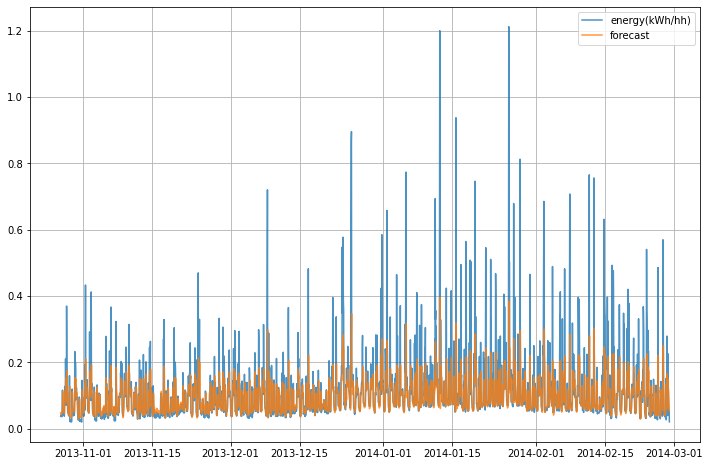

In [17]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_270685/1181257990.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


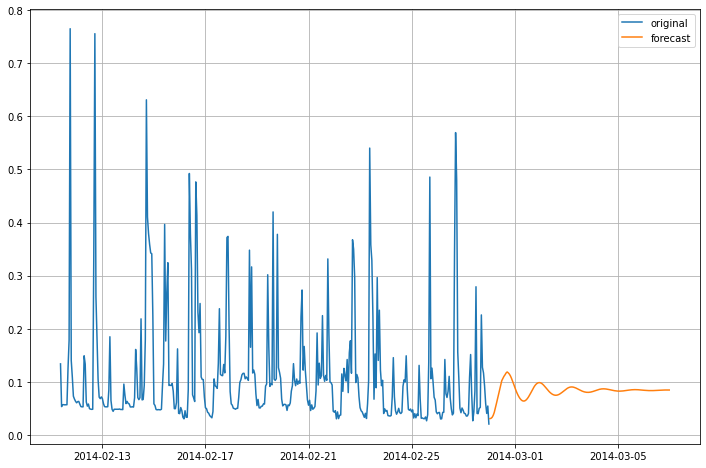

In [18]:


# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

# Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)

# Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [20]:
#deep_learner.save_lstm_model()

In [21]:
deep_learner.evaluateMSE()

0.006974235682653302

In [22]:
deep_learner.evaluateRMSE()

0.08351188946882535

In [23]:
deep_learner.evaluateMAE()

0.03834135672074854

In [24]:
deep_learner.evaluateMAPE()

30.213385816528138